In [33]:
%matplotlib inline
import numpy as np

import os.path, json, io, pandas
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon, shape
from shapely import wkb, wkt
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType, StringType, IntegerType

from descartes import PolygonPatch
import overpy


In [237]:
a = ["a"]
print a.append("b")
print a

None
['a', 'b']


In [238]:
### Helper functions

def bbox(bounds):
    return (bounds[1],bounds[0],bounds[3],bounds[2])

def nodeToFeature(node):
    properties = node.tags
    properties.append(Point(node.lon, node.lat).wkt)
    return {
        "type": "Feature",
        "properties": properties,
        "geometry": {
            "type": "Point",
            "coordinates": [
                float(node.lon),
                float(node.lat)
            ]
        }
    }

def nodesToFeatures(nodes):
    """
    :param nodes
    :type nodes from overpy.Result (result.nodes)
    :return:
    """
    features = []
    for node in nodes:
        features.append(nodeToFeature(node))
    return features

In [239]:
OVERPASS_API         = overpy.Overpass()

BASE_DIR             = os.path.join(os.path.abspath('.'), 'work-flow')
URBAN_BOUNDRIES_FILE = '06_Europe_Cities_Boundries_with_Labels_Population.geo.json'

URBAN_BOUNDRIES_PATH = os.path.join(BASE_DIR,URBAN_BOUNDRIES_FILE)
POIS_PATH            = os.path.join(BASE_DIR, "pois.json")

geo_df = GeoDataFrame.from_file(URBAN_BOUNDRIES_PATH)

print geo_df.columns
print geo_df.index
print geo_df.ix[0]
geo_sub = geo_df

# overWritePois = True

if not os.path.isfile(POIS_PATH):
    for index, row in geo_sub.iterrows():
        payload = """
            [out:json][timeout:40];
            (
              node["tourism"="gallery"]%(box)s;
              node["tourism"="artwork"]%(box)s;
              node["tourism"="museum"]%(box)s;
            );
            out body;""" % {'box': str(bbox(row.geometry.bounds))}
        result = OVERPASS_API.query(payload)
        pois.extend(nodesToFeatures(result.nodes))

if not os.path.isfile(POIS_PATH):
    # Write POIs file
    with io.open(POIS_PATH, 'w+', encoding='utf-8') as f:
        f.write(unicode(json.dumps(pois, ensure_ascii= False)))
    

Index([  u'ADM0NAME',    u'ADM0_A3',   u'ADM1NAME',  u'ELEVATION',
       u'FEATURECLA',  u'GEONAMEID',   u'GN_ASCII',     u'GN_POP',
           u'ISO_A2',   u'MEGACITY',       u'NAME',  u'NAMEASCII',
        u'POPEU2013',   u'TIMEZONE',     u'UN_FID', u'URAU_CITY_',
         u'geometry'],
      dtype='object')
RangeIndex(start=0, stop=41, step=1)
ADM0NAME                                            Switzerland
ADM0_A3                                                     CHE
ADM1NAME                                                 ZHrich
ELEVATION                                                     0
FEATURECLA                                      Admin-1 capital
GEONAMEID                                            2.6579e+06
GN_ASCII                                                 Zurich
GN_POP                                                   341730
ISO_A2                                                       CH
MEGACITY                                                      1
NAME      

In [38]:
# Add a WKT column for use later
geo_df['wkt'] = pandas.Series(
    map(lambda geom: str(geom.to_wkt()), geo_df['geometry']), 
    index=geo_df.index, dtype='string')


### Create a dataframe from GeoPanadas

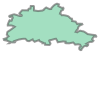

In [39]:
boundries_from_pd = sqlContext.createDataFrame(geo_df)
wkt.loads(boundries_from_pd.filter(
        boundries_from_pd.NAMEASCII == 'Berlin'
    ).collect()[0].wkt)

In [43]:
df = boundries_from_pd.select(boundries_from_pd.NAMEASCII, 
                              boundries_from_pd.POPEU2013.cast(IntegerType())
                             )

df = df.sort(df.POPEU2013.desc())
df.show()


+----------+---------+
| NAMEASCII|POPEU2013|
+----------+---------+
|    Berlin|  3375222|
|    Madrid|  3207247|
|      Rome|  2638842|
|     Paris|  2240681|
| Bucharest|  2134030|
|    Vienna|  1741246|
|  Budapest|  1735711|
|   Hamburg|  1734272|
|    Warsaw|  1724404|
| Barcelona|  1611822|
|    Munich|  1388308|
|     Milan|  1262101|
|    Prague|  1243201|
|     Sofia|  1213542|
|  Brussels|  1174624|
|Birmingham|  1088900|
| Marseille|  1045805|
|   Cologne|  1024373|
|    Naples|   959052|
|     Turin|   872091|
+----------+---------+
only showing top 20 rows



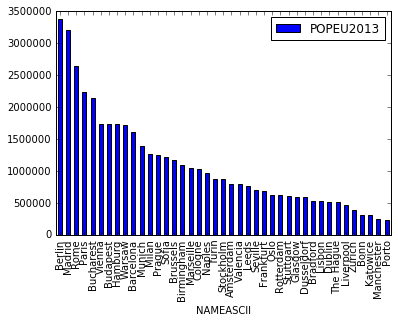

In [46]:
df = df.toPandas()
df.plot.bar(x='NAMEASCII')

In [48]:
# Lets look at the data

boundries_from_pd.registerTempTable('boundries')
sqlContext.sql("SELECT NAME FROM boundries").show()

+----------+
|      NAME|
+----------+
|    Zurich|
|    Prague|
|     Sofia|
|    Vienna|
|  Brussels|
|    Berlin|
|   Hamburg|
|    Munich|
|   Cologne|
| Frankfurt|
| Stuttgart|
|Ddsseldorf|
|      Bonn|
|    Madrid|
| Barcelona|
|  Valencia|
|   Seville|
|     Paris|
| Marseille|
|    Dublin|
+----------+
only showing top 20 rows



In [256]:
pois_df = sqlContext.read.json(POIS_PATH)
# pois_df.printSchema()
print pois_df.count()
# pois_df.show()
rec = pois_df.take(1)[0]
# # Point(rec.geometry.coordinates).wkt
# # 'POINT (8.537308599999999 47.3382614)'

pois_df = pois_df.toPandas()
pois_df.count()
# # # Add a WKT column for use later
# # geo_df['wkt'] = pandas.Series(
# #     map(lambda geom: str(geom.to_wkt()), geo_df['geometry']), 
# #     index=geo_df.index, dtype='string')


def toWktColumn(coords):
    return (Point(coords).wkt)

pois_df['wkt'] = pandas.Series(
    map(lambda geom: toWktColumn(geom.coordinates), pois_df['geometry']), 
    index=pois_df.index, dtype='string')

pois_df = sqlContext.createDataFrame(pois_df)

6956


### Count the number of museums in Zurich

1358


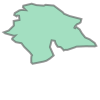

In [257]:
pois_df.registerTempTable("pois")
museums = sqlContext.sql(
    "SELECT geometry, \
    properties.name, \
    properties.tourism \
    FROM pois WHERE properties.tourism = 'museum'")
print museums.count()

# select museums within Zurich
zurich = sqlContext.sql("SELECT wkt, POPEU2013 \
    FROM boundries WHERE NAME = 'Zurich'")

jsonstr = zurich.toJSON().take(1)[0]
jsonobj = json.loads(jsonstr)
zurich_boundry = wkt.loads(jsonobj['wkt'])
zurich_boundry

In [258]:
museums_in_zurich = museums.rdd.filter(lambda r: Point(r['geometry']['coordinates']).within(zurich_boundry))
museums_in_zurich.count()

25

### SQL is nice but...

Most of the time in Spark SQL you can use Strings (in SQL) to reference columns but there are two cases where  you’ll want to use the Column objects rather than Strings :

* In Spark SQL DataFrame columns are allowed to have the same name, they’ll be given unique names inside of Spark SQL, but this means that you can’t reference them with the column name only as this becomes ambiguous.

* When you need to manipulate columns using expressions like Adding two columns to each other, Twice the value of this column or even Is the column value larger than 0 ?, you won’t be able to use simple strings and will need the Column reference.

* Finally if you need renaming, cast or any other complex feature, you’ll need the Column reference too.


### Joins, Spatial Predicate, Broadcast Variables, UDFs

In [259]:
# Exercise
# for each city count the number of museums
# and return a DF with:
# city_name, museum_count

# SQL VErsion
# cities_df = sqlContext.sql(
#     """
#     SELECT properties.NAMEASCII AS city_name, 
#         geometry AS city_geom FROM boundries
#     """)

cities_df = boundries_from_pd.select(
    (boundries_from_pd.NAMEASCII).alias('city_name'),
    (boundries_from_pd.wkt).alias('city_geom'))

cities_df.cache()

# Create a broadcast variable
# Broadcast http://spark.apache.org/docs/latest/programming-guide.html#broadcast-variables
# Broadcast variables allow the programmer to keep a read-only variable cached on each machine 
# rather than shipping a copy of it with tasks. They can be used, for example, to give every node 
# a copy of a large input dataset in an efficient manner. Spark also attempts to distribute broadcast
# variables using efficient broadcast algorithms to reduce communication cost.

# Spark actions are executed through a set of stages, separated by distributed “shuffle” 
# operations. Spark automatically broadcasts the common data needed by tasks within each stage. 
# The data broadcasted this way is cached in serialized form and deserialized before running each task. 
# This means that explicitly creating broadcast variables is only useful when tasks across multiple 
# stages need the same data or when caching the data in deserialized form is important.

# Broadcast variables are created from a variable v by calling SparkContext.broadcast(v). The broadcast 
# variable is a wrapper around v, and its value can be accessed by calling the value method.

_cities_df = cities_df.toJSON().collect()[0:3]
broadcastCitiesJSON = sc.broadcast(_cities_df)

# wkt.loads(json.loads(broadcastCitiesJSON.value[0])['city_geom'])

In [260]:
def get_city_name(poi_geom):
    # get an array of dict [(city_name, city_geom)]
    cities = map(lambda c: {
                    'city_name': json.loads(c)['city_name'],
                    'city_wkt': wkt.loads(json.loads(c)['city_geom'])
                }, broadcastCitiesJSON.value)

    print cities[0]
    shply_poi = shape(poi_geom.asDict())
    city = filter(lambda city: shply_poi.within(city['city_wkt']), cities)
    name = None
    if city:
        name = city[0]['city_name']
    return name

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SQLContext.registerFunction
# Registers a python function (including lambda function) as a UDF so it can be used in SQL statements.
# In addition to a name and the function itself, the return type can be optionally specified. When the 
# return type is not given it default to a string and conversion will automatically be done. For any other 
# return type, the produced object must match the specified type.

sqlContext.udf.register("get_city_name", get_city_name, StringType())

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.udf
# Creates a Column expression representing a user defined function (UDF).    
get_city_name_udf = udf(get_city_name, StringType())

# SQL VERSION
# museums_df = sqlContext.sql(
#     "SELECT geometry as museum_geom, \
#     properties.name as museum_name, \
#     get_city_name(geometry) as city_name \
#     FROM pois WHERE properties.tourism = 'museum'")


museums_df = pois_df.select(
    (pois_df.geometry).alias('museum_geom'),
    (pois_df.properties.name).alias('museum_name'),
    (get_city_name_udf(pois_df.geometry).alias('city_name'))
)

museums_df.registerTempTable("museums")
                       
print museums_df.count()
# print cities_df.count()
# print museums_df.where(museums_df.city_name.isNotNull()).count()


6956


In [55]:
museums_df.cache() # Try without and with
print museums_df.where(museums_df.city_name.isNotNull()).count()

350


 ### Grouping 

In [261]:
grouped_by_city = museums_df.dropna().groupBy('city_name')

In [262]:
grouped_by_city.count().show()

+---------+-----+
|city_name|count|
+---------+-----+
|   Prague|  214|
|    Sofia|   22|
|   Zurich|   39|
+---------+-----+



### Adding population column
Accoring to our algorithm we will have to divide count by the the population to scale it per capita

In [92]:
# lets recreate the cities DF this time including the population
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.cast
# Convert the column into type dataType
cities_df = boundries_from_pd.select(
    (boundries_from_pd.NAMEASCII).alias('city_name'),
    (boundries_from_pd.POPEU2013.cast(IntegerType())).alias('population'),
    (boundries_from_pd.wkt).alias('city_geom'))

cities_df.cache()


DataFrame[city_name: string, population: int, city_geom: string]

In [93]:
museums_df = museums_df.dropna()

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.join
# Joins with another DataFrame, using the given join expression.

# The following performs a full outer join between df1 and df2.

# Parameters:
# other – Right side of the join
# on – a string for join column name, a list of column names, , a join expression (Column) or a list of Columns.
#      If on is a string or a list of string indicating the name of the join column(s), the column(s) must exist 
#      on both sides, and this performs an equi-join.
# how – str, default ‘inner’. One of inner, outer, left_outer, right_outer, leftsemi.

df = museums_df.join(cities_df, museums_df.city_name == cities_df.city_name).select(
    museums_df.museum_geom,
    museums_df.museum_name,    
    museums_df.city_name,
    cities_df.population,
    cities_df.city_geom
)

df.printSchema( )
# Love Spark!

grouped_by_city = df.groupBy('city_name', 'population')
grouped_by_city = grouped_by_city.count()
            

root
 |-- museum_geom: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- museum_name: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- city_geom: string (nullable = true)



### Calculating the score

In [94]:
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumnRenamed
grouped_by_city = grouped_by_city.withColumnRenamed('count', 'museum_count')

cultural_weight_lookup = { 'museum': 1, 'gallery': 2, 'artwork': 3 }

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumn
grouped_by_city = grouped_by_city.withColumn('cultural_score', (
                            grouped_by_city.museum_count/grouped_by_city.population
                           )*10000*cultural_weight_lookup['museum'])



In [106]:
grouped_by_city.show()

+---------+----------+------------+-------------------+
|city_name|population|museum_count|     cultural_score|
+---------+----------+------------+-------------------+
|   Zurich|    380777|          39| 1.0242215259850254|
|   Prague|   1243201|         214|  1.721362836741605|
|    Sofia|   1213542|          22|0.18128750385235945|
+---------+----------+------------+-------------------+



In [ ]:
# understanding de/serialization

from pyspark.rdd import RDD
dl = [
    (u'2', {u'director': u'David Lean'}), 
    (u'7', {u'director': u'Andrew Dominik'})
]

dl_rdd = sc.parallelize(dl)
tmp = dl_rdd._to_java_object_rdd()
tmp2 = sc._jvm.SerDe.javaToPython(tmp)
t = RDD(tmp2, sc)
t.count()

tmp = t._to_java_object_rdd()
tmp2 = sc._jvm.SerDe.javaToPython(tmp)
t = RDD(tmp2, sc)
t.count() 

### Spatial Spark

SpatialSpark aims to provide efficient spatial operations using Apache Spark. It can be used as a Spark library for spatial extension as well as a standalone application to process large scale spatial join operations.

SpatialSpark has been compiled and tested on Spark 1.6.1. For geometry operations and data structures for indexes, well known JTS library is used.

#### Spatial Partition

Generate a spatial partition from input dataset, currently Fixed-Grid Partition (FGP), Binary-Split Partition (BSP) and Sort-Tile Partition (STP) are supported.

#### Spatial Range Query

Spatial range query includes both indexed and non-indexed query. For non-indexed query, a full scan is performed on the dataset and returns filtered results. 

In [203]:
from ast import literal_eval as make_tuple
print "Java Spark context version:", sc._jsc.version()
spatialspark = sc._jvm.spatialspark

rectangleA = Polygon([(0, 0), (0, 10), (10, 10), (10, 0)])
rectangleB = Polygon([(-4, -4), (-4, 4), (4, 4), (4, -4)])
rectangleC = Polygon([(7, 7), (7, 8), (8, 8), (8, 7)])
pointD = Point((-1, -1))

def geomABWithId():
  return sc.parallelize([
    (0L, rectangleA.wkt),
    (1L, rectangleB.wkt)
  ])

def geomCWithId():
  return sc.parallelize([
    (0L, rectangleC.wkt)
  ])

def geomABCWithId():
  return sc.parallelize([
  (0L, rectangleA.wkt),
  (1L, rectangleB.wkt),
  (2L, rectangleC.wkt)])

def geomDWithId():
  return sc.parallelize([
    (0L, pointD.wkt)
  ])


dfAB = sqlContext.createDataFrame(geomABWithId(), ['id', 'wkt'])
dfABC = sqlContext.createDataFrame(geomABCWithId(), ['id', 'wkt'])
dfC = sqlContext.createDataFrame(geomCWithId(), ['id', 'wkt'])
dfD = sqlContext.createDataFrame(geomDWithId(), ['id', 'wkt'])
# Supported Operators: Within, WithinD, Contains, Intersects, Overlaps, NearestD
SpatialOperator      = spatialspark.operator.SpatialOperator 
BroadcastSpatialJoin = spatialspark.join.BroadcastSpatialJoin

joinRDD = BroadcastSpatialJoin.apply(sc._jsc, dfABC._jdf, dfAB._jdf, SpatialOperator.Intersects(), 0.0)

joinRDD.count()

Java Spark context version: 1.6.1


5L

In [204]:
results = joinRDD.collect()
map(lambda result: make_tuple(result.toString()), results)

# [(0, 0), (1, 1), (2, 0)] read as:
# ID 0 is within 0
# ID 1 is within 1
# ID 2 is within 0

[(0, 1), (0, 0), (1, 1), (1, 0), (2, 0)]

In [ ]:
# Exercise: Find out if geometry with ID 2 overlaps geometry with ID 1

### Perform Analysis on All Features and All Cities


In [263]:
from pyspark.sql.functions import monotonicallyIncreasingId

# create dataframe with (id, geometry) for POIs
# 1. Add and ID Column to POIs

pois_df = pois_df.withColumn("id", monotonicallyIncreasingId())
pois_tuple_id_wkt = pois_df.select(pois_df.id, pois_df.wkt)
pois_tuple_id_wkt.show()
pois_tuple_id_wkt.printSchema()
print pois_tuple_id_wkt.count()

+---+--------------------+
| id|                 wkt|
+---+--------------------+
|  0|POINT (8.53730859...|
|  1|POINT (8.5323192 ...|
|  2|POINT (8.5359353 ...|
|  3|POINT (8.54174989...|
|  4|POINT (8.52711700...|
|  5|POINT (8.5399549 ...|
|  6|POINT (8.4561452 ...|
|  7|POINT (8.50017549...|
|  8|POINT (8.52973519...|
|  9|POINT (8.5385422 ...|
| 10|POINT (8.53656130...|
| 11|POINT (8.480677 4...|
| 12|POINT (8.5322963 ...|
| 13|POINT (8.5712495 ...|
| 14|POINT (8.53632269...|
| 15|POINT (8.54473710...|
| 16|POINT (8.55004669...|
| 17|POINT (8.56659329...|
| 18|POINT (8.530695 4...|
| 19|POINT (8.52670160...|
+---+--------------------+
only showing top 20 rows

root
 |-- id: long (nullable = false)
 |-- wkt: string (nullable = true)

6956


root
 |-- id: long (nullable = false)
 |-- wkt: string (nullable = true)

41
+-----------+--------------------+
|         id|                 wkt|
+-----------+--------------------+
|          0|MULTIPOLYGON (((8...|
|          1|MULTIPOLYGON (((1...|
|          2|MULTIPOLYGON (((2...|
|          3|MULTIPOLYGON (((1...|
|          4|MULTIPOLYGON (((4...|
| 8589934592|MULTIPOLYGON (((1...|
| 8589934593|MULTIPOLYGON (((1...|
| 8589934594|MULTIPOLYGON (((1...|
| 8589934595|MULTIPOLYGON (((6...|
| 8589934596|MULTIPOLYGON (((8...|
|17179869184|MULTIPOLYGON (((9...|
|17179869185|MULTIPOLYGON (((6...|
|17179869186|MULTIPOLYGON (((7...|
|17179869187|MULTIPOLYGON (((-...|
|17179869188|MULTIPOLYGON (((2...|
|25769803776|MULTIPOLYGON (((-...|
|25769803777|MULTIPOLYGON (((-...|
|25769803778|MULTIPOLYGON (((2...|
|25769803779|MULTIPOLYGON (((5...|
|25769803780|MULTIPOLYGON (((-...|
+-----------+--------------------+
only showing top 20 rows



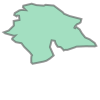

In [264]:
boundries_from_pd = boundries_from_pd.withColumn("id", monotonicallyIncreasingId())
boundries_tuple_id_wkt = boundries_from_pd.select(boundries_from_pd.id, boundries_from_pd.wkt)
boundries_tuple_id_wkt.printSchema()
print boundries_from_pd.count()
boundries_tuple_id_wkt.show()
wkt.loads(boundries_tuple_id_wkt.take(1)[0].wkt)

In [216]:
# inZurich = boundries_from_pd.map(
#   wkt.loads(boundries_from_pd.wkt).within(zurich_boundry)
# )

In [265]:
joinPoiBdryRDD = BroadcastSpatialJoin.apply(sc._jsc, pois_tuple_id_wkt._jdf, boundries_tuple_id_wkt._jdf, SpatialOperator.Within(), 0.0)

In [266]:
print joinPoiBdryRDD.count()

joinResults = map(lambda result: make_tuple(result.toString()), joinPoiBdryRDD.collect())


6135


In [267]:
print pois_tuple_id_wkt.count()
print boundries_tuple_id_wkt.count()
print joinResults[695]

6956
41
(729, 4)
